In [1]:
%pylab inline
import pandas as pd
import time
#import numpy as np
import pickle
import joblib
from joblib import Parallel, delayed
import os
import csv
from pandas import *
import datetime as dt
from datetime import date, datetime, timedelta
from sklearn import svm, preprocessing
from collections import Counter
from sklearn import linear_model as lm
import math as math
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve
plt.style.use('seaborn-white')
pandas.set_option('display.max_columns', None)

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#with open("samplestargetsONE.pkl",'rb') as f: samples, targets = pickle.load(f)

In [24]:
trainingSets = (np.concatenate([(samples[h]) for h in samples.keys()[:1500]]))
trainingSett = np.concatenate([(targets[h]) for h in targets.keys()[:1500]])
testSets = (np.concatenate([(samples[h]) for h in samples.keys()[1500:]]))
testSett = np.concatenate([(targets[h]) for h in targets.keys()[1500:]])
trainingSetscaled = scl.transform(trainingSets)
testSetscaled = scl.transform(testSets)

In [25]:
static = ['admittype', 'ethnicity', 'gender', 'age', 'weight']
vitals = ['Heart Rate', 'Respiratory Rate','O2 saturation pulseoxymetry', 'Non Invasive Blood Pressure mean', 
        'O2 Flow', 'Inspired O2 Fraction', 'Arterial CO2 Pressure', 'PH (Arterial)', 'Arterial O2 pressure', 
        'Mean Airway Pressure', 'Ventilator Mode', 'Peak Insp. Pressure', 'Plateau Pressure', 'Minute Volume', 
        'Tidal Volume (observed)', 'PEEP set', 'Creatinine', 'Hematocrit (serum)', 'BUN']
inputs = ['Fentanyl (Concentrate)', 'Midazolam (Versed)', 'Propofol','Fentanyl', 'Dexmedetomidine (Precedex)', 
        'Morphine Sulfate','Hydromorphone (Dilaudid)', 'Lorazepam (Ativan)']
sbts = ['SBT Started', 'SBT Stopped', 'SBT Successfully Completed', 'SBT Deferred']

In [ ]:
# Learn transform to standardize vectors

sclv = {}
for v in ['Heart Rate','Respiratory Rate','O2 saturation pulseoxymetry','Non Invasive Blood Pressure mean','PEEP set',
         'Inspired O2 Fraction','Arterial CO2 Pressure','PH (Arterial)','Arterial O2 pressure','Peak Insp. Pressure']:
    sclv[v] = []
    sclv[v] = StandardScaler()
    sclv[v].fit(np.transpose(trainingSets)[vitals.index(v)+5].reshape(-1,1))
    
def transform(scl, val):
    return scl.transform(np.array([val]).reshape(-1,1))

In [536]:
with open("baseFrames.pkl",'wb') as f: pickle.dump((extffn, sclv),f)

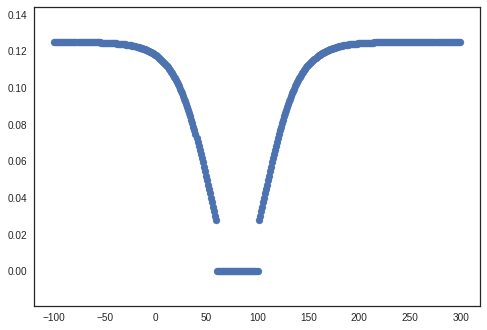

In [270]:
# Reward function for vitals

regulateVitals ={}
v = 'Heart Rate'
regulateVitals[v] = [np.nan, transform(sclv[v], 60), transform(sclv[v], 100), transform(sclv[v], 130), 1] 
v = 'Respiratory Rate'
regulateVitals[v] = [np.nan, transform(sclv[v], 12), transform(sclv[v], 20), transform(sclv[v], 30), 1]
v = 'O2 saturation pulseoxymetry'
regulateVitals[v] = [transform(sclv[v], 88), transform(sclv[v],92), transform(sclv[v],100), transform(sclv[v],100), 1]
v = 'Non Invasive Blood Pressure mean'
regulateVitals[v] = [np.nan, transform(sclv[v], 70), transform(sclv[v], 100), np.nan, 1]
v = 'Inspired O2 Fraction'
regulateVitals[v] = [transform(sclv[v], 0), transform(sclv[v], 0), transform(sclv[v], 70), transform(sclv[v], 100), 1]
v = 'Arterial CO2 Pressure'
regulateVitals[v] = [np.nan, transform(sclv[v], 30), transform(sclv[v], 50), transform(sclv[v], 60), 1]
v = 'PH (Arterial)'
regulateVitals[v] = [transform(sclv[v], 7.3), transform(sclv[v], 7.35), transform(sclv[v], 7.45), np.nan, 1]
v = 'Arterial O2 pressure'
regulateVitals[v] = [np.nan, transform(sclv[v], 45), transform(sclv[v], 75), np.nan, 1]
v = 'Peak Insp. Pressure'
regulateVitals[v] = [np.nan, transform(sclv[v], 16), transform(sclv[v], 20), np.nan, 1]
v = 'PEEP set'
regulateVitals[v] = [np.nan, transform(sclv[v], 4), transform(sclv[v], 6), transform(sclv[v], 8), 1] 
#regulateVitals['O2 Flow'] = [np.nan, 0, 100, np.nan, 2]
#regulateVitals['Mean Airway Pressure'] = [np.nan, 0, 100, np.nan, 2]
#regulateVitals['Ventilator Mode'] = [np.nan, 0, 100, np.nan, 2]
#regulateVitals['Plateau Pressure'] = [np.nan, 0, 100, np.nan, 2]
#regulateVitals['Minute Volume'] = [np.nan, 0, 100, np.nan, 2]
#regulateVitals['Tidal Volume (observed)'] = [np.nan, 0, 100, np.nan, 2]
#regulateVitals['Creatinine'] = [np.nan, 0, 100, np.nan, 2]
#regulateVitals['Hematocrit (serum)'] = [np.nan, 0, 100, np.nan, 2]
#regulateVitals['BUN'] = [np.nan, 0, 100, np.nan, 2]

def getVitReward(vit, val, regulateVitals):
    reward = 0
    lower = regulateVitals[vit][1]
    upper = regulateVitals[vit][2]
    mid = (upper - lower)/2.0
    importance = regulateVitals[vit][4]
    diff2 = float(upper-lower)/2
    scale = 1/((math.exp(diff2)-1)/(1+math.exp(diff2)))
    if (val > upper) or (val < (lower)): 
                reward = -0.125*importance*scale*(1/(1+math.exp(lower-val)) - 1/(1+math.exp(upper-val)) - (1/scale))
    #reward = 10/(sqrt(2*pi)*s)*e**(-0.5*(float(val-mid)/s)**2)
    #reward = -scale*(1/(1+0.2*math.exp(0.2*(lower-val))) - 1/(1+5*math.exp(0.2*(upper-val))) - 1/(1+0.2))
    #print val, upper, lower, reward, 2*(math.exp(diff2)-1)/(1+math.exp(diff2))
    return reward

vit = 'Heart Rate'
scatter(np.arange(-100,300, 1), 
        [getVitReward(vit, val, regulateVitals) for val in sclv[vit].transform(np.arange(-100,300, 1).reshape(-1,1))])

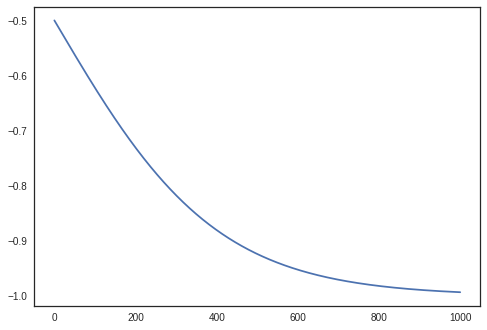

In [291]:
plot(range(1000), [-1/float(1 + math.exp(-0.005 * (x)) ) for x in range(1000)])

In [268]:
x=100; 2*-float(1 - math.exp(-0.005 * (x-6)))

-0.7499954634345984

In [360]:
extffn[hadms[3]]

,timestamp,hadm,subject,icudays,admittype,ethnicity,gender,age,weight,ventilated,sbt,Heart Rate,Respiratory Rate,O2 saturation pulseoxymetry,Non Invasive Blood Pressure mean,O2 Flow,Inspired O2 Fraction,Arterial CO2 Pressure,PH (Arterial),Arterial O2 pressure,Mean Airway Pressure,Ventilator Mode,Peak Insp. Pressure,Plateau Pressure,Minute Volume,Tidal Volume (observed),PEEP set,Creatinine,Hematocrit (serum),BUN,Fentanyl (Concentrate),Midazolam (Versed),Propofol,Fentanyl,Dexmedetomidine (Precedex),Morphine Sulfate,Hydromorphone (Dilaudid),Lorazepam (Ativan),duration,intubations
0,2116-03-24 15:00:00,113326,13593,47,1,0,1,59,62.0,0,unknown,125.000000,12.000000,97.000000,67.000000,7.5,50.0,53.0,7.30,86.0,10.0,49.0,34.0,18.0,6.3,520.0,5.0,5.5,39.1,35.0,0,0,149,2487,0,0,0,11,0.0,0
1,2116-03-24 16:00:00,113326,13593,47,1,0,1,59,62.0,1,unknown,105.000000,15.000000,100.000000,70.000000,7.5,50.0,53.0,7.30,86.0,10.0,49.0,34.0,18.0,6.3,520.0,5.0,5.5,39.1,35.0,0,0,129,2487,0,0,0,11,1.0,1
2,2116-03-24 17:00:00,113326,13593,47,1,0,1,59,62.0,1,unknown,105.000000,16.500000,98.000000,70.000000,7.5,50.0,53.0,7.30,86.0,10.0,49.0,34.0,18.0,6.3,520.0,5.0,5.5,39.1,35.0,0,0,2345,2487,0,0,0,11,2.0,1
3,2116-03-24 18:00:00,113326,13593,47,1,0,1,59,62.0,1,unknown,105.000000,17.000000,100.000000,68.000000,7.5,50.0,53.0,7.30,86.0,10.0,49.0,34.0,18.0,6.3,520.0,5.0,5.5,39.1,35.0,0,0,76,2487,0,0,0,11,3.0,1
4,2116-03-24 19:00:00,113326,13593,47,1,0,1,59,62.0,1,unknown,106.000000,19.000000,99.000000,61.000000,7.5,50.0,53.0,7.30,86.0,10.0,49.0,24.0,17.0,8.2,489.0,5.0,5.5,39.1,35.0,0,0,1414,2487,0,0,0,11,4.0,1
5,2116-03-24 20:00:00,113326,13593,47,1,0,1,59,62.0,1,unknown,101.666667,14.000000,98.666667,55.500000,7.5,50.0,53.0,7.30,86.0,10.0,49.0,24.0,17.0,8.2,489.0,5.0,5.5,39.1,35.0,0,0,1340,2487,0,0,0,11,5.0,1
6,2116-03-24 21:00:00,113326,13593,47,1,0,1,59,62.0,1,unknown,104.000000,16.000000,97.000000,60.500000,7.5,50.0,53.0,7.30,86.0,10.0,49.0,24.0,17.0,8.2,489.0,5.0,5.5,39.1,35.0,0,0,1266,2487,0,0,0,11,6.0,1
7,2116-03-24 22:00:00,113326,13593,47,1,0,1,59,62.0,1,unknown,102.000000,17.000000,97.000000,58.500000,7.5,40.0,53.0,7.30,86.0,9.0,49.0,22.0,18.0,7.0,449.0,5.0,5.5,39.1,35.0,0,0,2,2437,0,0,0,10,7.0,1
8,2116-03-24 23:00:00,113326,13593,47,1,0,1,59,62.0,1,unknown,101.250000,16.000000,96.000000,52.750000,7.5,40.0,53.0,7.30,86.0,9.0,49.0,22.0,18.0,7.0,449.0,5.0,5.5,39.1,35.0,1,0,0,2437,0,0,0,10,8.0,1
9,2116-03-25 00:00:00,113326,13593,47,1,0,1,59,62.0,1,SBT Deferred,103.000000,16.400000,95.400000,70.400000,7.5,40.0,53.0,7.30,86.0,9.0,49.0,23.0,17.0,7.7,469.0,5.0,5.5,39.1,35.0,1,0,0,2437,0,0,0,10,9.0,1


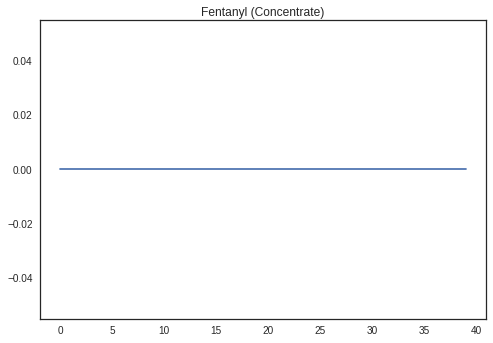

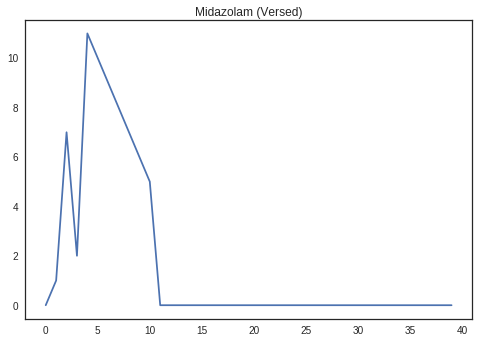

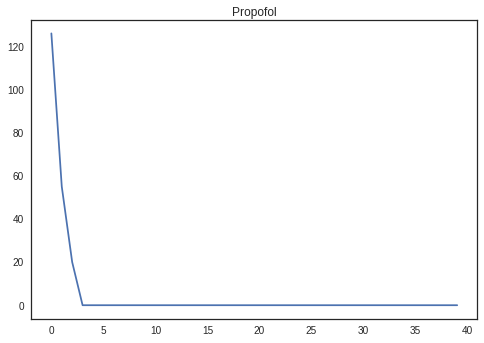

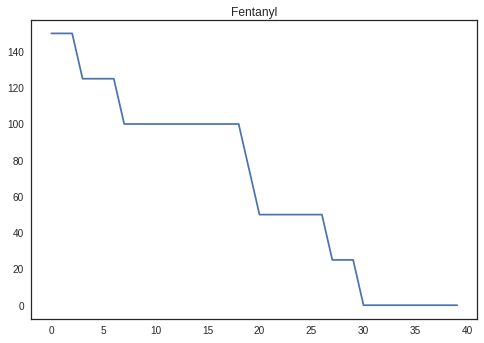

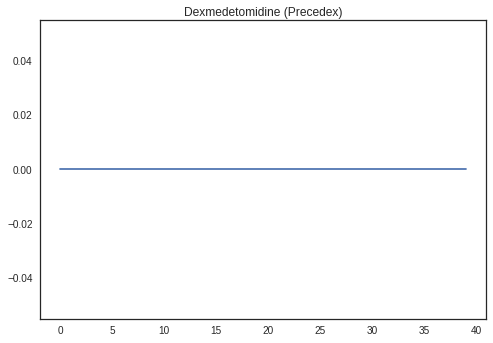

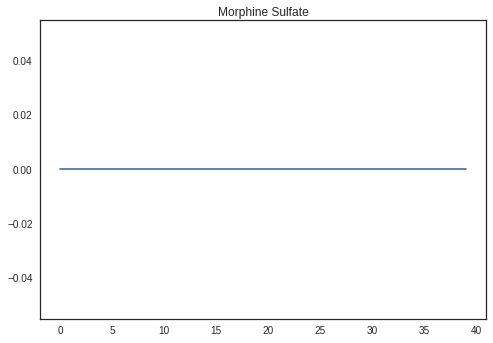

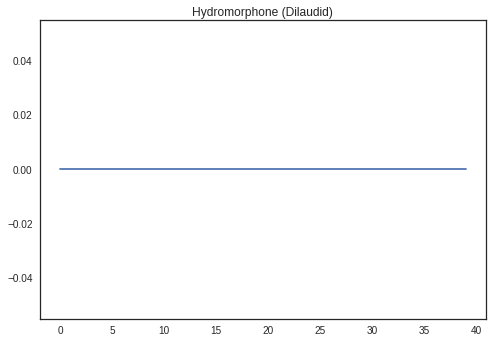

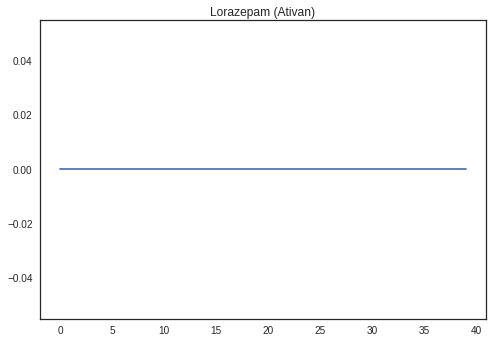

In [325]:
for x in inputs:
    figure()
    plot(extffn[hadms[100]][x])
    title(x)

In [532]:
tmp = getSamples(extffn[hadms[10]], hadms[10])

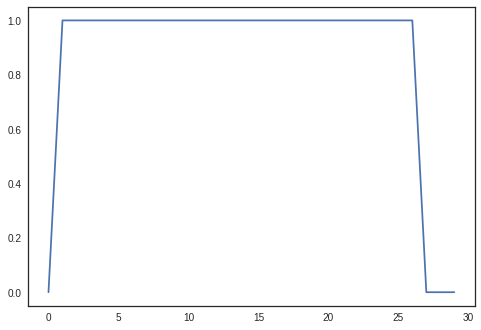

In [535]:
plot(extffn[hadms[10]].ventilated)

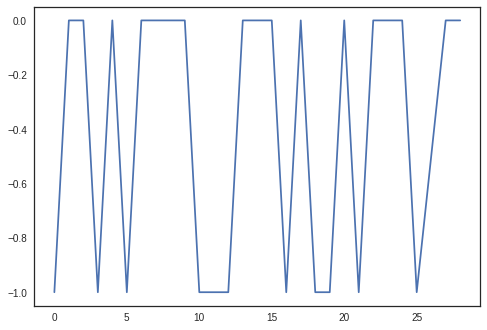

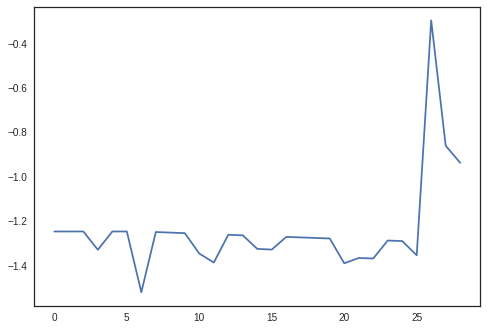

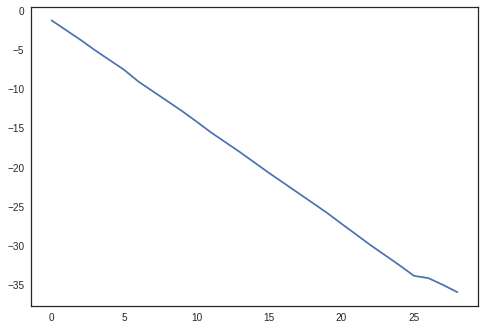

In [534]:
plot(np.transpose(tmp['actions'])[9])
figure()
plot(np.transpose(tmp['rewards']))
figure()
plot(np.cumsum(np.transpose(tmp['rewards'])))

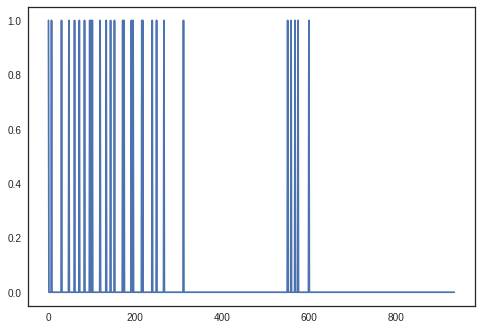

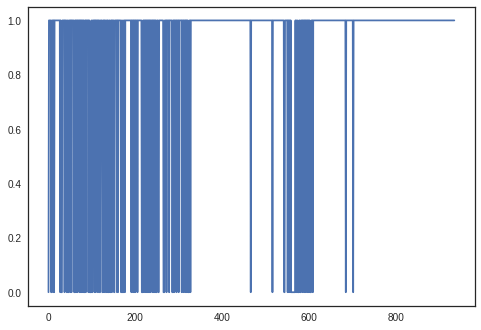

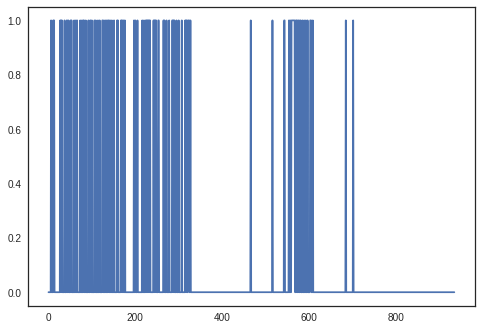

In [526]:
plot(np.transpose(tmp['actions'])[9]>0)
figure()
plot(np.transpose(tmp['actions'])[9]==0)
figure()
plot(np.transpose(tmp['actions'])[9]<0)

#plot(-(np.transpose(tmp['actions'])[9]==0))


In [540]:
len(np.concatenate(tmp['currStates'][0]))

34

In [544]:
np.ones(len(tmp['actions'])) * tmp['hadm']

array([ 163893.,  163893.,  163893.,  163893.,  163893.,  163893.,
        163893.,  163893.,  163893.,  163893.,  163893.,  163893.,
        163893.,  163893.,  163893.,  163893.,  163893.,  163893.,
        163893.,  163893.,  163893.,  163893.,  163893.,  163893.,
        163893.,  163893.,  163893.,  163893.,  163893.])

In [567]:
with open("pickles/preppedBaseFrames.pkl",'rb') as f: eextffn, hadmsList, currStates, nextStates, actions, rewards = pickle.load(f)


In [552]:
eextffn[hadms[0]]

,timestamp,hadm,subject,icudays,admittype,ethnicity,gender,age,weight,ventilated,sbt,Heart Rate,Respiratory Rate,O2 saturation pulseoxymetry,Non Invasive Blood Pressure mean,O2 Flow,Inspired O2 Fraction,Arterial CO2 Pressure,PH (Arterial),Arterial O2 pressure,Mean Airway Pressure,Ventilator Mode,Peak Insp. Pressure,Plateau Pressure,Minute Volume,Tidal Volume (observed),PEEP set,Creatinine,Hematocrit (serum),BUN,Fentanyl (Concentrate),Midazolam (Versed),Propofol,Fentanyl,Dexmedetomidine (Precedex),Morphine Sulfate,Hydromorphone (Dilaudid),Lorazepam (Ativan),duration,intubations
0,2169-01-26 08:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,76.000000,17.000000,100.0,66.0,9.241284,50.0,40.0,7.35,235.0,9.0,49.0,26.0,20.0,8.00,491.0,5.0,0.8,38.1,6.0,0,3,590,3275,0,0,0,12,1.0,1
1,2169-01-26 09:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,104.500000,21.500000,99.5,80.0,9.241284,50.0,40.0,7.35,235.0,9.0,49.0,26.0,20.0,8.00,491.0,5.0,0.8,38.1,6.0,0,3,590,3275,0,0,0,12,2.0,1
2,2169-01-26 10:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,90.333333,16.333333,100.0,76.0,9.241284,50.0,40.0,7.35,235.0,9.0,49.0,26.0,20.0,8.00,491.0,5.0,0.8,38.1,6.0,0,3,1077,3275,0,0,0,12,3.0,1
3,2169-01-26 11:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,100.000000,22.000000,100.0,76.0,9.241284,50.0,40.0,7.35,235.0,8.0,2.0,22.0,18.0,8.00,510.0,5.0,0.8,38.1,6.0,0,3,1261,3275,0,0,0,12,4.0,1
4,2169-01-26 12:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,88.000000,17.000000,100.0,81.0,9.241284,50.0,40.0,7.35,235.0,8.0,2.0,22.0,18.0,8.00,510.0,5.0,0.8,38.1,6.0,0,3,560,3275,0,0,0,12,5.0,1
5,2169-01-26 13:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,102.000000,16.000000,99.0,65.0,9.241284,50.0,37.0,7.35,207.0,8.0,2.0,22.0,18.0,8.00,510.0,5.0,0.8,38.1,6.0,0,3,763,3250,0,0,0,12,6.0,1
6,2169-01-26 14:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,112.000000,16.000000,99.0,74.0,9.241284,50.0,37.0,7.35,207.0,8.0,2.0,22.0,18.0,8.00,510.0,5.0,0.8,38.1,6.0,0,3,1127,3125,0,0,0,12,7.0,1
7,2169-01-26 15:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,98.000000,16.000000,100.0,86.0,9.241284,50.0,37.0,7.35,207.0,8.0,2.0,22.0,18.0,8.00,510.0,5.0,0.8,38.1,6.0,0,3,689,3125,0,0,0,12,8.0,1
8,2169-01-26 16:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,94.000000,16.000000,100.0,95.0,9.241284,40.0,37.0,7.35,207.0,9.0,49.0,24.0,19.0,8.50,468.0,5.0,0.8,38.1,6.0,0,3,1393,3125,0,0,0,12,9.0,1
9,2169-01-26 17:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,100.000000,15.500000,100.0,96.0,9.241284,40.0,37.0,7.35,207.0,9.0,49.0,24.0,19.0,8.50,468.0,5.0,0.8,38.1,6.0,0,3,815,3125,0,0,0,12,10.0,1


In [559]:
def produceSamples(samples, h):
    #try:
    frame = cp.deepcopy(extffn)
    samples[h] = getSamples(frame, h)        
    #except BaseException:
    #    samples[h] = [0]
    return samples[h]

In [605]:
import copy as cp
extffn = cp.deepcopy(eextffn)

In [615]:
def getSamples(frame, h):
    
    samples = {}; currStates = []; actions = []; nextStates = []; rewards = []
        
    for t in range(len(frame[h]) - 1):
        
        # Initialize states:
        currState = frame[h].iloc[[t]]
        nextState = frame[h].iloc[[t+1]]
        reward = 0
        # Initialize actions:
        action = np.zeros(10)                                 # action[0] is ventOn/ventOff; action[1-8] are 7 sed dosages
        if (nextState.ventilated.item() == 1):                      # if vent on in next, action was turn/keep vent on in curr
            action[0] = 1
        s = 1
        for sedative in inputs:
            if sedative != 'Propofol':
                if (currState[sedative].item() < nextState[sedative].item()):
                    action[s] = 1
                elif (currState[sedative].item() > nextState[sedative].item()):
                    action[s] = -1
                else:
                    action[s] = 0
            else:
                if (currState[sedative].item() == 0) and (nextState[sedative].item() > 0):
                    action[s] = 0.5
                elif (currState[sedative].item() > 0) and (nextState[sedative].item() == 0):
                    action[s] = -0.5
                else:
                    action[s] = 0
#             if ((t==0) and (currState[sedative].item() != 0)):
#                 action[s] = 1
            s += 1
        action[s] = sum(action[1:9])
        
        # Penalize vent duration: no penalty for first 6 hours ### MAX = -1 ###
        scaleFactor = 0.5*currState.intubations.item()
        threshold = 6                                     
        if (currState.duration.item() >= threshold) and (nextState.ventilated.item() == 1):
            reward -= scaleFactor*float(1 - math.exp(-0.005 * (currState.duration.item() - threshold)))
            
        intubating = ((currState.ventilated.item() == 0) and (action[0] == 1))
        stayingVented = ((currState.ventilated.item() == 1) and (action[0] == 1))
        extubating = ((currState.ventilated.item() == 1) and (action[0] == 0))
        stayingOff = ((currState.ventilated.item() == 0) and (action[0] == 0))
        
        # Reward from vitals outside normal ranges (at any time) ### MAX = -1.2 ###
        for vital in regulateVitals.keys():
            value = currState[vital].item()
            scaleFactor = 1
            if (stayingVented or intubating): 
                reward -= scaleFactor * getVitReward(vital, value, regulateVitals)
            else:
                reward -= scaleFactor * 1.2*getVitReward(vital, value, regulateVitals)
            
        # Reward for sharp changes in key vitals ### MAX = -1.2 ###
        for vital in ['Heart Rate', 'Respiratory Rate', 'Non Invasive Blood Pressure mean']:
            currval = currState[vital].item()
            nextval = nextState[vital].item()
            #print vital, currval
            if currval == 0: currval = nextval # buggy
            change = abs(currval - nextval)/float(currval)
            scaleFactor = 0.25
            if change > 0.2:
                if (stayingVented or intubating): 
                    reward -= min(1, scaleFactor * change)
                else: 
                    reward -= min(1.2, 1.2 * scaleFactor * change)
        
        # Reward from vitals outside min/max at extubation: ### MIN = 2, MAX < -1.6 ###
        if extubating:  
            reward += 1.5
        if (extubating or stayingOff):
            for vital in regulateVitals.keys():
                value = currState[vital].item()
                maxv = float(regulateVitals[vital][4])
                minv = float(regulateVitals[vital][0])
                if ((math.isnan(minv) != 1) and value < vital[0]):
                    reward -= 0.1
                if ((math.isnan(maxv) != 1) and value > vital[4]):
                    reward -= 0.1
                    
        # For staying off the vent:
        if (stayingOff and (currState.intubations.item() != 0)): ### MIN = 1 ###
            reward += 1
        # Penalize reintubation: ### MAX = -2 ###
        if (intubating and currState.intubations.item() != 0):
            reward -= 1
        # Bonus reward for successful extubation (with no reintubation within admission) -- cheating?
        if max(frame[h][t+1:].ventilated) == 0:
            reward += 0
        
        #print '-------Total reward:', round(reward.item()), '-------'
        
        # Remove irrelevant entries
        for entry in ['timestamp', 'hadm', 'subject', 'icudays', 'ventilated', 'sbt']:
            del currState[entry], nextState[entry]
        currStates.append(currState.values)
        nextStates.append(nextState.values)
        actions.append(action)
        rewards.append(reward)
    
    samples[h] = {"hadm" : h, "currStates" : currStates, "nextStates" : nextStates, "actions": actions, "rewards": rewards}
    
    return samples[h]

In [583]:
frame = cp.deepcopy(extffn[h])

In [599]:
currState = frame.iloc[[5]]

In [618]:
for i in extffn.keys()[:2]:
    print i
    allSamples[i] = produceSamples(allSamples, i)

139265
[-1.4605910883545086, -1.3077118461706143, -1.3343689970604362, -1.3044525085432865, -1.2476343146170217, -1.2476342936707914, -1.2501280540744502, -1.2526093767962072, -1.2550783239740295, -1.2575349356258678, -1.3693697776974962, -1.2624270000436424, -1.333028875940093, -1.2672550132565834, -1.269650991916195, -1.2720350214716711, -1.2744071597452862, -1.2767674669299038, -1.279147377543199, -1.3412185008428499, -1.2838093660001646, -1.3486229360385829, -1.3821731909928987, -1.3588689689814601, -1.376297687587486, -1.295233888508562, -1.391240336233409, -1.3997221956029329, -1.3680983461207776, -1.3041924551059794, -1.3064041671804743, -1.4325986341385444, -1.3107946626287548, -1.3129734798271389, -1.4545285223152784, -1.3716464563471997, -1.3194450087847351, -1.3215806461056978, -1.3237056885448457, -1.3258199775179371, -1.327923875431525, -1.3300172801104928, -1.3849848592746814, -1.3341729736171224, -1.3362352115607943, -1.4683530125168451, -1.391254808309022, -1.3423604176

In [620]:
allSamples[i]

{'actions': [array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 1.,

In [595]:
extffn[h]

,timestamp,hadm,subject,icudays,admittype,ethnicity,gender,age,weight,ventilated,sbt,Heart Rate,Respiratory Rate,O2 saturation pulseoxymetry,Non Invasive Blood Pressure mean,O2 Flow,Inspired O2 Fraction,Arterial CO2 Pressure,PH (Arterial),Arterial O2 pressure,Mean Airway Pressure,Ventilator Mode,Peak Insp. Pressure,Plateau Pressure,Minute Volume,Tidal Volume (observed),PEEP set,Creatinine,Hematocrit (serum),BUN,Fentanyl (Concentrate),Midazolam (Versed),Propofol,Fentanyl,Dexmedetomidine (Precedex),Morphine Sulfate,Hydromorphone (Dilaudid),Lorazepam (Ativan),duration,intubations
0,2179-11-21 01:00:00,122879,11638,12,1,1,1,71,73.0,0,unknown,70.000000,12.750000,97.250000,66.666667,15.0,40.0,46.0,7.32,81.0,9.0,0.0,22.0,17.0,7.5,452.0,5.0,2.7,39.3,70.0,0,2,0,50,0,22,0,0,0.0,0
1,2179-11-21 02:00:00,122879,11638,12,1,1,1,71,73.0,1,unknown,70.000000,11.000000,98.000000,67.000000,15.0,40.0,46.0,7.32,81.0,9.0,0.0,22.0,17.0,7.5,452.0,5.0,2.7,39.3,70.0,0,3,0,50,0,22,0,0,1.0,1
2,2179-11-21 03:00:00,122879,11638,12,1,1,1,71,73.0,1,unknown,70.000000,18.000000,95.000000,65.000000,15.0,40.0,46.0,7.32,81.0,9.0,0.0,22.0,17.0,7.5,452.0,5.0,2.7,39.3,70.0,0,16,0,50,0,22,0,0,2.0,1
3,2179-11-21 04:00:00,122879,11638,12,1,1,1,71,73.0,1,unknown,70.000000,12.000000,94.000000,65.000000,15.0,40.0,46.0,7.32,81.0,13.0,49.0,20.0,17.0,7.1,559.0,8.0,2.7,39.3,70.0,0,5,0,50,0,22,0,0,3.0,1
4,2179-11-21 05:00:00,122879,11638,12,1,1,1,71,73.0,1,unknown,70.000000,20.000000,98.000000,65.000000,15.0,40.0,39.0,7.37,284.0,13.0,49.0,20.0,17.0,7.1,559.0,8.0,2.7,39.3,70.0,3,26,0,50,0,22,0,0,4.0,1
5,2179-11-21 06:00:00,122879,11638,12,1,1,1,71,73.0,1,unknown,70.000000,20.000000,99.000000,65.000000,15.0,40.0,39.0,7.37,284.0,13.0,49.0,20.0,17.0,7.1,559.0,8.0,2.7,39.3,70.0,3,24,0,50,0,22,0,0,5.0,1
6,2179-11-21 07:00:00,122879,11638,12,1,1,1,71,73.0,1,unknown,70.000000,20.000000,96.000000,65.000000,15.0,40.0,39.0,7.37,284.0,13.0,49.0,20.0,17.0,7.1,559.0,8.0,2.7,39.3,70.0,2,22,0,50,0,22,0,0,6.0,1
7,2179-11-21 08:00:00,122879,11638,12,1,1,1,71,73.0,1,unknown,70.000000,20.000000,97.000000,65.000000,15.0,40.0,39.0,7.37,284.0,12.0,49.0,20.0,18.0,8.3,416.0,8.0,2.7,39.3,70.0,2,20,0,50,0,22,0,0,7.0,1
8,2179-11-21 09:00:00,122879,11638,12,1,1,1,71,73.0,1,unknown,70.000000,20.000000,97.000000,65.000000,15.0,40.0,39.0,7.37,284.0,12.0,49.0,20.0,18.0,8.3,416.0,8.0,2.7,39.3,70.0,2,18,0,50,0,22,0,0,8.0,1
9,2179-11-21 10:00:00,122879,11638,12,1,1,1,71,73.0,1,unknown,70.000000,20.000000,96.000000,65.000000,15.0,40.0,38.0,7.41,96.0,12.0,49.0,20.0,18.0,8.3,416.0,8.0,2.7,39.3,70.0,2,14,0,50,0,22,0,0,9.0,1


In [581]:
allSamples = {}
allSamples = Parallel(n_jobs=2, verbose=100)(delayed(produceSamples)(allSamples, i) for i in extffn.keys()[:3])

            timestamp    hadm  subject  icudays  admittype  ethnicity  gender  \
0 2146-11-24 18:00:00  106507    44781       49          1          1       0   

   age  weight  ventilated      sbt  Heart Rate  Respiratory Rate  \
0   65    75.0           0  unknown        81.0              13.0   

   O2 saturation pulseoxymetry  Non Invasive Blood Pressure mean   O2 Flow  \
0                        100.0                              73.0  9.241284   

   Inspired O2 Fraction  Arterial CO2 Pressure  PH (Arterial)  \
0                  50.0                   33.0           7.45   

   Arterial O2 pressure  Mean Airway Pressure  Ventilator Mode  \
0                 256.5                   8.0             49.0   

   Peak Insp. Pressure  Plateau Pressure  Minute Volume  \
0                 21.0              16.0            6.8   

   Tidal Volume (observed)  PEEP set  Creatinine  Hematocrit (serum)   BUN  \
0                    565.0       5.0         1.0                33.6  15.0   

 

JoblibAttributeError: JoblibAttributeError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/tigress/BEE/mimic/usr/np6/miniconda2/lib/python2.7/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    169     pkg_name = mod_name.rpartition('.')[0]
    170     main_globals = sys.modules["__main__"].__dict__
    171     if alter_argv:
    172         sys.argv[0] = fname
    173     return _run_code(code, main_globals, None,
--> 174                      "__main__", fname, loader, pkg_name)
        fname = '/tigress/BEE/mimic/usr/np6/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = 'ipykernel'
    175 
    176 def run_module(mod_name, init_globals=None,
    177                run_name=None, alter_sys=False):
    178     """Execute a module's code without importing it

...........................................................................
/tigress/BEE/mimic/usr/np6/miniconda2/lib/python2.7/runpy.py in _run_code(code=<code object <module> at 0x2b0583ec37b0, file "/...2.7/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/tigress/BEE/mimic/usr/np6/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from '/tigress/BEE...python2.7/site-packages/ipykernel/kernelapp.pyc'>}, init_globals=None, mod_name='__main__', mod_fname='/tigress/BEE/mimic/usr/np6/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='ipykernel')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x2b0583ec37b0, file "/...2.7/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/tigress/BEE/mimic/usr/np6/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from '/tigress/BEE...python2.7/site-packages/ipykernel/kernelapp.pyc'>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/tigress/BEE/mimic/usr/np6/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/tigress/BEE/mimic/usr/np6/miniconda2/lib/python2.7/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/tigress/BEE/mimic/usr/np6/miniconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    469             return self.subapp.start()
    470         if self.poller is not None:
    471             self.poller.start()
    472         self.kernel.start()
    473         try:
--> 474             ioloop.IOLoop.instance().start()
    475         except KeyboardInterrupt:
    476             pass
    477 
    478 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/tigress/BEE/mimic/usr/np6/miniconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    157             PollIOLoop.configure(ZMQIOLoop)
    158         return PollIOLoop.current(*args, **kwargs)
    159     
    160     def start(self):
    161         try:
--> 162             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    163         except ZMQError as e:
    164             if e.errno == ETERM:
    165                 # quietly return on ETERM
    166                 pass

...........................................................................
/tigress/BEE/mimic/usr/np6/miniconda2/lib/python2.7/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
/tigress/BEE/mimic/usr/np6/miniconda2/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/tigress/BEE/mimic/usr/np6/miniconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/tigress/BEE/mimic/usr/np6/miniconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/tigress/BEE/mimic/usr/np6/miniconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/tigress/BEE/mimic/usr/np6/miniconda2/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/tigress/BEE/mimic/usr/np6/miniconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/tigress/BEE/mimic/usr/np6/miniconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'allSamples = {}\nallSamples = Parallel(n_jobs=...ples)(allSamples, i) for i in extffn.keys()[:3])', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2017-05-08T00:44:56.336628', u'msg_id': u'3F128E6A2209464C9701F4689D95C22B', u'msg_type': u'execute_request', u'session': u'4A63E0D3A1844BC487228477C8F54F9C', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'3F128E6A2209464C9701F4689D95C22B', 'msg_type': u'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['4A63E0D3A1844BC487228477C8F54F9C']
        msg = {'buffers': [], 'content': {u'allow_stdin': True, u'code': u'allSamples = {}\nallSamples = Parallel(n_jobs=...ples)(allSamples, i) for i in extffn.keys()[:3])', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2017-05-08T00:44:56.336628', u'msg_id': u'3F128E6A2209464C9701F4689D95C22B', u'msg_type': u'execute_request', u'session': u'4A63E0D3A1844BC487228477C8F54F9C', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'3F128E6A2209464C9701F4689D95C22B', 'msg_type': u'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/tigress/BEE/mimic/usr/np6/miniconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['4A63E0D3A1844BC487228477C8F54F9C'], parent={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'allSamples = {}\nallSamples = Parallel(n_jobs=...ples)(allSamples, i) for i in extffn.keys()[:3])', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2017-05-08T00:44:56.336628', u'msg_id': u'3F128E6A2209464C9701F4689D95C22B', u'msg_type': u'execute_request', u'session': u'4A63E0D3A1844BC487228477C8F54F9C', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'3F128E6A2209464C9701F4689D95C22B', 'msg_type': u'execute_request', 'parent_header': {}})
    385         if not silent:
    386             self.execution_count += 1
    387             self._publish_execute_input(code, parent, self.execution_count)
    388 
    389         reply_content = self.do_execute(code, silent, store_history,
--> 390                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    391 
    392         # Flush output before sending the reply.
    393         sys.stdout.flush()
    394         sys.stderr.flush()

...........................................................................
/tigress/BEE/mimic/usr/np6/miniconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code=u'allSamples = {}\nallSamples = Parallel(n_jobs=...ples)(allSamples, i) for i in extffn.keys()[:3])', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = u'allSamples = {}\nallSamples = Parallel(n_jobs=...ples)(allSamples, i) for i in extffn.keys()[:3])'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/tigress/BEE/mimic/usr/np6/miniconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=(u'allSamples = {}\nallSamples = Parallel(n_jobs=...ples)(allSamples, i) for i in extffn.keys()[:3])',), **kwargs={'silent': False, 'store_history': True})
    496             )
    497         self.payload_manager.write_payload(payload)
    498 
    499     def run_cell(self, *args, **kwargs):
    500         self._last_traceback = None
--> 501         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = (u'allSamples = {}\nallSamples = Parallel(n_jobs=...ples)(allSamples, i) for i in extffn.keys()[:3])',)
        kwargs = {'silent': False, 'store_history': True}
    502 
    503     def _showtraceback(self, etype, evalue, stb):
    504         # try to preserve ordering of tracebacks and print statements
    505         sys.stdout.flush()

...........................................................................
/tigress/BEE/mimic/usr/np6/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell=u'allSamples = {}\nallSamples = Parallel(n_jobs=...ples)(allSamples, i) for i in extffn.keys()[:3])', store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/tigress/BEE/mimic/usr/np6/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>], cell_name='<ipython-input-581-b26bbd38e89f>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<ExecutionResult object at 2b05edf0e610, executi..._before_exec=None error_in_exec=None result=None>)
   2816 
   2817         try:
   2818             for i, node in enumerate(to_run_exec):
   2819                 mod = ast.Module([node])
   2820                 code = compiler(mod, cell_name, "exec")
-> 2821                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x2b05dbecd7b0, file "<ipython-input-581-b26bbd38e89f>", line 2>
        result = <ExecutionResult object at 2b05edf0e610, executi..._before_exec=None error_in_exec=None result=None>
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])

...........................................................................
/tigress/BEE/mimic/usr/np6/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x2b05dbecd7b0, file "<ipython-input-581-b26bbd38e89f>", line 2>, result=<ExecutionResult object at 2b05edf0e610, executi..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x2b05dbecd7b0, file "<ipython-input-581-b26bbd38e89f>", line 2>
        self.user_global_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, 'Categorical': <class 'pandas.core.categorical.Categorical'>, ...}
        self.user_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, 'Categorical': <class 'pandas.core.categorical.Categorical'>, ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/tigress/BEE/mimic/usr/np6/ventRL/<ipython-input-581-b26bbd38e89f> in <module>()
      1 
----> 2 
      3 
      4 
      5 allSamples = {}
      6 allSamples = Parallel(n_jobs=2, verbose=100)(delayed(produceSamples)(allSamples, i) for i in extffn.keys()[:3])
      7 
      8 
      9 
     10 

...........................................................................
/home/np6/.local/lib/python2.7/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=2), iterable=<generator object <genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=2)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
AttributeError                                     Mon May  8 00:44:56 2017
PID: 10805  Python 2.7.12: /tigress/BEE/mimic/usr/np6/miniconda2/bin/python
...........................................................................
/home/np6/.local/lib/python2.7/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function produceSamples>
        args = ({}, 139265)
        kwargs = {}
        self.items = [(<function produceSamples>, ({}, 139265), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/tigress/BEE/mimic/usr/np6/ventRL/<ipython-input-559-cbb41744312a> in produceSamples(samples={}, h=139265)
      1 
      2 
----> 3 
      4 def produceSamples(samples, h):
      5     #try:
      6     samples[h] = getSamples(extffn, h)        
      7     #except BaseException:
      8     #    samples[h] = [0]
      9     return samples[h]
     10 

...........................................................................
/tigress/BEE/mimic/usr/np6/ventRL/<ipython-input-576-bf7f359b47d6> in getSamples(extffn={100011:               timestamp    hadm  subject  icuday...      0.0            1  

[219 rows x 40 columns], 100035:               timestamp    hadm  subject  icuday...  1  
179            1  

[180 rows x 40 columns], 100068:              timestamp    hadm  subject  icudays... 
30                   1       0.0            1  , 100104:               timestamp    hadm  subject  icuday...  2  
187            2  

[188 rows x 40 columns], 100210:               timestamp    hadm  subject  icuday...      0.0            1  

[235 rows x 40 columns], 100215:               timestamp    hadm  subject  icuday...      0.0            1  

[113 rows x 40 columns], 100227:              timestamp    hadm  subject  icudays...          1  
54            1  
55            1  , 100263:              timestamp    hadm  subject  icudays...          1  
53            1  
54            1  , 100406:               timestamp    hadm  subject  icuday...  1  
258            1  

[259 rows x 40 columns], 100416:               timestamp    hadm  subject  icuday...      0.0            1  

[314 rows x 40 columns], ...}, h=139265)
      4     samples = {}; currStates = []; actions = []; nextStates = []; rewards = []
      5         
      6     for t in range(len(frame) - 1):
      7         
      8         # Initialize states:
----> 9         currState = frame.iloc[[t]]
     10         nextState = frame.iloc[[t+1]]
     11         reward = 0
     12         print currState
     13         # Initialize actions:

AttributeError: 'dict' object has no attribute 'iloc'
___________________________________________________________________________

In [616]:
x = getSamples(extffn, hadms[0])

[-1.4605910883545086, -1.3077118461706143, -1.3343689970604362, -1.3044525085432865, -1.2476343146170217, -1.2476342936707914, -1.2501280540744502, -1.2526093767962072, -1.2550783239740295, -1.2575349356258678, -1.3693697776974962, -1.2624270000436424, -1.333028875940093, -1.2672550132565834, -1.269650991916195, -1.2720350214716711, -1.2744071597452862, -1.2767674669299038, -1.279147377543199, -1.3412185008428499, -1.2838093660001646, -1.3486229360385829, -1.3821731909928987, -1.3588689689814601, -1.376297687587486, -1.295233888508562, -1.391240336233409, -1.3997221956029329, -1.3680983461207776, -1.3041924551059794, -1.3064041671804743, -1.4325986341385444, -1.3107946626287548, -1.3129734798271389, -1.4545285223152784, -1.3716464563471997, -1.3194450087847351, -1.3215806461056978, -1.3237056885448457, -1.3258199775179371, -1.327923875431525, -1.3300172801104928, -1.3849848592746814, -1.3341729736171224, -1.3362352115607943, -1.4683530125168451, -1.391254808309022, -1.3423604176037098,

In [632]:
with open("pickles/preppedBaseFrames.pkl",'rb') as f: allSamples, hadmsList, currStates, nextStates, actions, rewards = pickle.load(f)
